In [1]:
import pandas as pd
from reload_recursive import reload_recursive
import os
from loguru import logger
from pathlib import Path
import json
import numpy as np
from tqdm.notebook import tqdm
import re
import sys
import nibabel as nib

import mri_data
import monai_training

In [2]:
reload_recursive(mri_data)
reload_recursive(monai_training)

from mri_data.file_manager import DataSet, scan_3Tpioneer_bids
from mri_data import file_manager as fm
from mri_data import utils
from monai_training.preprocess import DataSetProcesser

In [3]:
logger.remove()

In [4]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
training_work_dirs = drive_root / "training_work_dirs"
dataroot = drive_root / "3Tpioneer_bids"
clinical_data_root = drive_root / "Secure_Data" / "Large"
project_dataroot = msmri_home / "data"

In [5]:
keep_cols = ["ms_type", "flair_contrast"]
df_full = pd.read_csv(project_dataroot / "clinical_data_full.csv", index_col="subid")
df_full = df_full[keep_cols]
df_full.index.name = "subject_id"
try:
    df_full.insert('dz_type', df_full['ms_type'])
except Exception:
    pass

df_full.loc[:, 'dz_type'] = df_full['ms_type']

df_full.loc[df_full['ms_type'] == 'CIS', 'dz_type'] = 'RRMS'
df_full.loc[df_full['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS']), 'dz_type'] = 'PMS'
df_full.loc[df_full['ms_type'].isin(['NIND', 'OIND', 'HC']), 'dz_type'] = '!MS'

df_full.loc[:, 'dz_type2'] = df_full['dz_type']
df_full.loc[df_full['dz_type'].isin(['RRMS', 'PMS']), 'dz_type2'] = 'MS'

### Automatic Segmentations

In [6]:
work_dir_names = ["choroid_pineal_pituitary3", "choroid_pineal_pituitary3-2", "choroid_pineal_pituitary3-3", "choroid_pineal_pituitary3-4"]
work_dirs = [training_work_dirs / name / "ensemble_output" for name in work_dir_names]
ensemble_datasets = [fm.scan_3Tpioneer_bids(work_dir, label="flair.t1_ensemble.nii.gz") for work_dir in work_dirs]

### Manual Segmentations

In [7]:
subjects = []
for dataset in ensemble_datasets:
    for scan in dataset:
        subjects.append(int(scan.subid))

In [8]:
def has_subject(scan, subjects: list[int]) -> bool:
    if int(scan.subid) in subjects:
        return True
    else:
        return False

In [9]:
orig_dataset_proc = DataSetProcesser.new_dataset(dataroot, fm.scan_3Tpioneer_bids, filters=fm.filter_first_ses)
orig_dataset_proc.filter([has_subject], [(subjects,)])
orig_dataset_proc.prepare_labels(["choroid_t1_flair", "pineal", "pituitary"], ["CH", "SRS", "DT", "ED"])
orig_dataset = orig_dataset_proc.dataset

100%|██████████| 40/40 [00:02<00:00, 15.16it/s]


In [10]:
auto_segs = {}
for dataset in ensemble_datasets:
    for scan in dataset:
        auto_segs[scan.subid] = scan.label_path

man_segs = {}
for scan in orig_dataset:
    man_segs[scan.subid] = scan.label_path

In [11]:
df = df_full.loc[subjects, :]

df = df_full[df_full.index.isin(subjects)]
for subid, _ in df.iterrows():
    df.loc[subid, ('manual_label',)] = man_segs[str(subid)]
    df.loc[subid, ('auto_label',)] = auto_segs[str(subid)]

for scan in orig_dataset:
    df.loc[int(scan.subid), ('scan_folder',)] = scan.root

In [12]:
def get_volumes(path):
    vol_stats = utils.compute_volume(path, index_mask_file=path)
    
    return tuple([stat[1] for stat in vol_stats])

In [13]:
for subid, _ in tqdm(df.iterrows()):
    try:
        man_vol = get_volumes(df.loc[subid, 'manual_label'])
    except Exception:
        print(scan.subid)
        continue
    try:
        assert len(man_vol) == 3
    except AssertionError:
        man_vol = [None, None, None]

    df.loc[subid, ['choroid_vol_man', 'pineal_vol_man', 'pituitary_vol_man']] = man_vol


    try:
        auto_vol = get_volumes(df.loc[subid, 'auto_label'])
    except Exception:
        print(subid)
        continue
    try:
        assert len(auto_vol) == 3
    except AssertionError:
        auto_vol = [None, None, None]
    
    df.loc[subid, ['choroid_vol_auto', 'pineal_vol_auto', 'pituitary_vol_auto']] = auto_vol

0it [00:00, ?it/s]

1038
1540


In [14]:
def get_dice_scores(label1, label2):
    seg1 = nib.load(label1).get_fdata()
    seg2 = nib.load(label2).get_fdata()
    choroid = utils.dice_score(seg1, seg2, seg1_val=1, seg2_val=1)
    pineal = utils.dice_score(seg1, seg2, seg1_val=2, seg2_val=2)
    pituitary = utils.dice_score(seg1, seg2, seg1_val=3, seg2_val=3)
    return choroid, pineal, pituitary

In [15]:
for subid, _ in df.iterrows():
    df.loc[subid, ['choroid_dice', 
                    'pineal_dice', 
                    'pituitary_dice']] = get_dice_scores(df.loc[subid, 'auto_label'], 
                                                        df.loc[subid, 'manual_label'])


### Automatic Segmentation Volumes

In [16]:
print("Choroid:")
choroid_ms_mean = df[df['dz_type'] == "RRMS"].choroid_vol_auto.mean()
choroid_ms_mean_w = df[(df['dz_type'] == "RRMS") & (df['flair_contrast'] == "WITH")].choroid_vol_auto.mean()
choroid_ms_mean_wo = df[(df['dz_type'] == "RRMS") & (df['flair_contrast'] == "WITHOUT")].choroid_vol_auto.mean()
choroid_notms_mean = df[df['dz_type'] == "!MS"].choroid_vol_auto.mean()
print("MS mean:             {:0.2f}".format(choroid_ms_mean))
print("MS mean w contrast:  {:0.2f}".format(choroid_ms_mean_w))
print("MS mean wo contrast: {:0.2f}".format(choroid_ms_mean_wo))
print("!MS mean:            {:0.2f}".format(choroid_notms_mean))

print("\nPineal")
pineal_ms_mean = df[df['dz_type'] == "RRMS"].pineal_vol_auto.mean()
pineal_ms_mean_w = df[(df['dz_type'] == "RRMS") & (df['flair_contrast'] == "WITH")].pineal_vol_auto.mean()
pineal_ms_mean_wo = df[(df['dz_type'] == "RRMS") & (df['flair_contrast'] == "WITHOUT")].pineal_vol_auto.mean()
pineal_notms_mean = df[df['dz_type'] == "!MS"].pineal_vol_auto.mean()
print("MS mean:             {:0.2f}".format(pineal_ms_mean))
print("MS mean w contrast:  {:0.2f}".format(pineal_ms_mean_w))
print("MS mean wo contrast: {:0.2f}".format(pineal_ms_mean_wo))
print("!MS mean:            {:0.2f}".format(pineal_notms_mean))

print("\nPituitary")
pituitary_ms_mean = df[df['dz_type'] == "RRMS"].pituitary_vol_auto.mean()
pituitary_ms_mean_w = df[(df['dz_type'] == "RRMS") & (df['flair_contrast'] == "WITH")].pituitary_vol_auto.mean()
pituitary_ms_mean_wo = df[(df['dz_type'] == "RRMS") & (df['flair_contrast'] == "WITHOUT")].pituitary_vol_auto.mean()
pituitary_notms_mean = df[df['dz_type'] == "!MS"].pituitary_vol_auto.mean()
print("MS mean:             {:0.2f}".format(pituitary_ms_mean))
print("MS mean w contrast:  {:0.2f}".format(pituitary_ms_mean_w))
print("MS mean wo contrast: {:0.2f}".format(pituitary_ms_mean_wo))
print("!MS mean:            {:0.2f}".format(pituitary_notms_mean))

Choroid:
MS mean:             1766.81
MS mean w contrast:  1892.98
MS mean wo contrast: 1609.09
!MS mean:            1922.68

Pineal
MS mean:             228.35
MS mean w contrast:  269.92
MS mean wo contrast: 176.39
!MS mean:            254.34

Pituitary
MS mean:             700.47
MS mean w contrast:  677.11
MS mean wo contrast: 729.67
!MS mean:            716.21


### Manual Segmentation Volumes

In [17]:
print("Choroid:")
choroid_ms_mean = df[df['dz_type'] == "RRMS"].choroid_vol_man.mean()
choroid_ms_mean_w = df[(df['dz_type'] == "RRMS") & (df['flair_contrast'] == "WITH")].choroid_vol_man.mean()
choroid_ms_mean_wo = df[(df['dz_type'] == "RRMS") & (df['flair_contrast'] == "WITHOUT")].choroid_vol_man.mean()
choroid_notms_mean = df[df['dz_type'] == "!MS"].choroid_vol_man.mean()
print("MS mean:             {:0.2f}".format(choroid_ms_mean))
print("MS mean w contrast:  {:0.2f}".format(choroid_ms_mean_w))
print("MS mean wo contrast: {:0.2f}".format(choroid_ms_mean_wo))
print("!MS mean:            {:0.2f}".format(choroid_notms_mean))

print("\nPineal")
pineal_ms_mean = df[df['dz_type'] == "RRMS"].pineal_vol_man.mean()
pineal_ms_mean_w = df[(df['dz_type'] == "RRMS") & (df['flair_contrast'] == "WITH")].pineal_vol_man.mean()
pineal_ms_mean_wo = df[(df['dz_type'] == "RRMS") & (df['flair_contrast'] == "WITHOUT")].pineal_vol_man.mean()
pineal_notms_mean = df[df['dz_type'] == "!MS"].pineal_vol_man.mean()
print("MS mean:             {:0.2f}".format(pineal_ms_mean))
print("MS mean w contrast:  {:0.2f}".format(pineal_ms_mean_w))
print("MS mean wo contrast: {:0.2f}".format(pineal_ms_mean_wo))
print("!MS mean:            {:0.2f}".format(pineal_notms_mean))

print("\nPituitary")
pituitary_ms_mean = df[df['dz_type'] == "RRMS"].pituitary_vol_man.mean()
pituitary_ms_mean_w = df[(df['dz_type'] == "RRMS") & (df['flair_contrast'] == "WITH")].pituitary_vol_man.mean()
pituitary_ms_mean_wo = df[(df['dz_type'] == "RRMS") & (df['flair_contrast'] == "WITHOUT")].pituitary_vol_man.mean()
pituitary_notms_mean = df[df['dz_type'] == "!MS"].pituitary_vol_man.mean()
print("MS mean:             {:0.2f}".format(pituitary_ms_mean))
print("MS mean w contrast:  {:0.2f}".format(pituitary_ms_mean_w))
print("MS mean wo contrast: {:0.2f}".format(pituitary_ms_mean_wo))
print("!MS mean:            {:0.2f}".format(pituitary_notms_mean))

Choroid:
MS mean:             1954.47
MS mean w contrast:  1956.55
MS mean wo contrast: 1951.61
!MS mean:            1880.28

Pineal
MS mean:             230.64
MS mean w contrast:  260.88
MS mean wo contrast: 189.06
!MS mean:            371.61

Pituitary
MS mean:             767.78
MS mean w contrast:  755.84
MS mean wo contrast: 784.20
!MS mean:            679.33


In [22]:
df.loc[:, ['choroid_difference']] = df['choroid_vol_man'] - df['choroid_vol_auto']
df.loc[:, ['pineal_difference']] = df['pineal_vol_man'] - df['pineal_vol_auto'] 
df.loc[:, ['pituitary_difference']] = df['pituitary_vol_man'] - df['pituitary_vol_auto']

Look at dice scores between MS and !MS

In [19]:
print("MS choroid dice:   {:0.2f}".format(df[df.dz_type2 == "MS"].choroid_dice.mean()))
print("!MS choroid dice:  {:0.2f}".format(df[df.dz_type2 == "!MS"].choroid_dice.mean()))

print("\n")
print("MS pineal dice:   {:0.2f}".format(df[df.dz_type2 == "MS"].pineal_dice.mean()))
print("!MS pineal dice:  {:0.2f}".format(df[df.dz_type2 == "!MS"].pineal_dice.mean()))

print("\n")
print("MS pituitary dice:   {:0.2f}".format(df[df.dz_type2 == "MS"].pituitary_dice.mean()))
print("!MS pituitary dice:  {:0.2f}".format(df[df.dz_type2 == "!MS"].pituitary_dice.mean()))

MS choroid dice:   0.73
!MS choroid dice:  0.73


MS pineal dice:   0.69
!MS pineal dice:  0.72


MS pituitary dice:   0.74
!MS pituitary dice:  0.78


Look at volume differences between auto and man for MS and !MS

In [20]:
print("MS choroid difference:   {:0.2f}".format(df[df.dz_type2 == "MS"].choroid_difference.mean()))
print("!MS choroid difference:  {:0.2f}".format(df[df.dz_type2 == "!MS"].choroid_difference.mean()))

print("\n")
print("MS pineal difference:   {:0.2f}".format(df[df.dz_type2 == "MS"].pineal_difference.mean()))
print("!MS pineal difference:  {:0.2f}".format(df[df.dz_type2 == "!MS"].pineal_difference.mean()))

print("\n")
print("MS pituitary difference:   {:0.2f}".format(df[df.dz_type2 == "MS"].pituitary_difference.mean()))
print("!MS pituitary difference:  {:0.2f}".format(df[df.dz_type2 == "!MS"].pituitary_difference.mean()))

MS choroid difference:   -184.77
!MS choroid difference:  59.78


MS pineal difference:   -7.08
!MS pineal difference:  -120.75


MS pituitary difference:   -76.63
!MS pituitary difference:  40.04


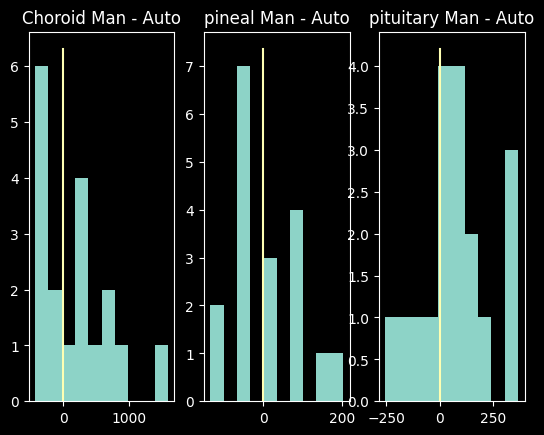

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3)
ax[0].hist(df.loc[df['dz_type2']=='MS', 'choroid_difference'])
ax[0].set_title("Choroid Man - Auto")
ax[0].plot([0, 0], ax[0].get_ylim())

ax[1].hist(df.loc[df['dz_type2']=='MS', 'pineal_difference'])
ax[1].set_title("pineal Man - Auto")
ax[1].plot([0, 0], ax[1].get_ylim())

ax[2].hist(df.loc[df['dz_type2']=='MS', 'pituitary_difference'])
ax[2].set_title("pituitary Man - Auto")
ax[2].plot([0, 0], ax[2].get_ylim())


### Inspect Segmentations

In [37]:
df.index.name = "subject_id"
df = df.sort_values(by=['dz_type2', "subject_id"])

/tmp/ipykernel_341066/1631151812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inference.sort_values(by=['dz_type2', "subject_id"], inplace=True)


In [40]:
df = df.sort_values(by=['choroid_difference'])

In [84]:
for i, row in df.iterrows():
    images = [Path(row['scan_folder']) / "flair.nii.gz", Path(row['scan_folder']) / "t1.nii.gz"]
    labels = [row['auto_label'], row['manual_label']]
    cmd = utils.open_itksnap_workspace_cmd(images, labels, win=True)
    df.loc[i, "itksnap_cmd"] = cmd

In [85]:
import pyperclip

pyperclip.copy(df.loc[1010, "itksnap_cmd"])

In [86]:
print(df.loc[1010, "itksnap_cmd"])

itksnap -g H:/3Tpioneer_bids/sub-ms1010/ses-20180208/flair.nii.gz -o H:/3Tpioneer_bids/sub-ms1010/ses-20180208/t1.nii.gz -s H:/training_work_dirs/choroid_pineal_pituitary3/ensemble_output/sub-ms1010/ses-20180208/flair.t1_ensemble.nii.gz H:/3Tpioneer_bids/sub-ms1010/ses-20180208/choroid_t1_flair-CH.pineal-CH.pituitary-CH.nii.gz


In [25]:
lines = ["# Notes", "\n\n"]
dz_type = ""
for i, row in df.iterrows():
    if row['dz_type2'] != dz_type:
        lines.extend([f"## {row['dz_type2']}", "\n\n"])
        dz_type = row['dz_type2']
    lines.extend([f"### {i}", "\n\n"])

In [26]:
import os

if not os.path.exists("seg_notes.md"):
    with open("seg_notes.md", 'w') as f:
        f.writelines(lines)